# routinize -- make them objects etc.

In [1]:
import numpy as np
from numpy import sqrt, pi
import matplotlib.pyplot as plt

from numpy import cos, sin

from matplotlib.colors import Normalize
from matplotlib import cm

In [18]:
from numbers import Integral
from numpy import pi

class ConductingCylinderOnGrid(object):
    def __init__(self, rho_arr, z_arr, R_ind, zd_ind, zu_ind, V0):
        ## Check arguments and set them members
        for _arg in (rho_arr, z_arr):
            assert isinstance(_arg, np.ndarray)
            assert _arg.ndim == 1
            assert np.diff(_arg).std() < 1e-15
        assert rho_arr[0] == 0
        for _arg in (R_ind, zd_ind, zu_ind): assert isinstance(_arg, Integral)
        for z_ind in (zd_ind, zu_ind): assert z_ind in range(-z_arr.size, z_arr.size)
        assert R_ind in range(-rho_arr.size, rho_arr.size)
        
        self.rho_arr, self.z_arr = rho_arr, z_arr
        self.drho, self.dz = rho_arr[1] - rho_arr[0], z_arr[1] - z_arr[0]
        self.R_ind, self.zd_ind, self.zu_ind = R_ind, zd_ind, zu_ind
        self.R = self.rho_arr[R_ind]
        self.zd, self.zu = self.z_arr[[zd_ind, zu_ind]]
        self.V0 = V0
        
        ## Construct surface points indice
        self.s1_ind = [(rho_ind, self.zu_ind) for rho_ind in range(self.R_ind+1)]
        self.s2_ind = [(self.R_ind, z_ind) for z_ind in range(self.zd_ind,self.zu_ind+1)]
        self.s3_ind = [(rho_ind, self.zd_ind) for rho_ind in range(self.R_ind+1)]
        self.surf_points_ind = np.array([*self.s1_ind, *self.s2_ind, *self.s3_ind])
        
        ## Construct a mask
        _Rho, _Z = np.meshgrid(self.rho_arr, self.z_arr, indexing='ij')
        self.mask = (_Rho <= self.R) & ((self.zd) <= _Z) & (_Z <= (self.zu))
        
        
    def eval_surf_charge_density(self, V):
        assert isinstance(V, np.ndarray)
        assert V.shape == (self.rho_arr.size, self.z_arr.size)
        epsil0 = 1.0 / (4*pi)
        s1_sigma = np.array([epsil0 * -(V[rho_ind, z_ind+1] - V[rho_ind,z_ind]) / self.dz for (rho_ind, z_ind) in self.s1_ind])
        s2_sigma = np.array([epsil0 * -(V[rho_ind+1, z_ind] - V[rho_ind,z_ind]) / self.drho for (rho_ind, z_ind) in self.s2_ind])
        s3_sigma = np.array([epsil0 * (V[rho_ind, z_ind] - V[rho_ind,z_ind-1]) / self.dz for (rho_ind, z_ind) in self.s3_ind])
        return s1_sigma, s2_sigma, s3_sigma
    
    def get_total_charge(self, V):
        s1_sigma, s2_sigma, s3_sigma = self.eval_surf_charge_density(V)
        
        s1_rho_arr = rho_arr[np.array(self.s1_ind)[:,0]]
        s1_rho_mul_sigma = s1_rho_arr * s1_sigma
        Q_s1 = 2*pi*np.sum(0.5 * (s1_rho_mul_sigma[:-1] + s1_rho_mul_sigma[1:]) * np.diff(s1_rho_arr))

        s3_rho_arr = rho_arr[np.array(self.s3_ind)[:,0]]
        s3_rho_mul_sigma = s3_rho_arr * s3_sigma
        Q_s3 = 2*pi*np.sum(0.5 * (s3_rho_mul_sigma[:-1] + s3_rho_mul_sigma[1:]) * np.diff(s3_rho_arr))

        s2_z_arr = z_arr[np.array(self.s2_ind)[:,1]]
        Q_s2 = 2*pi*self.R * np.sum(0.5 * (s2_sigma[:-1] + s2_sigma[1:]) * np.diff(s2_z_arr))

        Q_total = Q_s1 + Q_s2 + Q_s3
        return Q_total

In [48]:
import numpy as np

class Electric_Potential_At_Cylindrical_Coord(object):
    
    _max_iter_num = 10000
    
    def __init__(self, rho_arr, z_arr, bd_cond):
        
        ## Check arguments and set as members
        for _arg in (rho_arr, z_arr): assert isinstance(_arg, np.ndarray) and _arg.ndim == 1
        assert np.diff(rho_arr).std() < 1e-15 and np.diff(z_arr).std() < 1e-15
        self.rho_arr, self.z_arr = rho_arr, z_arr
        self.drho, self.dz = rho_arr[1] - rho_arr[0], z_arr[1] - z_arr[0]
        
        assert isinstance(bd_cond,np.ma.MaskedArray)
        assert bd_cond.shape == (rho_arr.size, z_arr.size)
        self.bd_cond = bd_cond
        
        ## Allocate and Initialize the potential array
        self.V = np.empty(self.bd_cond.shape, dtype=float)
        self.V[:] = np.random.rand(*self.bd_cond.shape)
        self.V[~self.bd_cond.mask] = self.bd_cond[~self.bd_cond.mask]
        
    def go_to_solution(self, stop_thres=1e-3):
        
        _c1 = 1.0 / (4.0/self.drho**2 + 2.0/self.dz**2)
        _c2 = 1.0 / (2.0/self.drho**2 + 2.0/self.dz**2)        
        _converged = False
        
        for _ in range(self._max_iter_num):
            
            _V_prev = self.V.copy()

            self.V[0,1:-1] = _c1 * (
                4.0 / self.drho**2 * self.V[1,1:-1]
                + 1.0 / self.dz**2 * (self.V[0,2:] + self.V[0,:-2])
            )
            self.V[1:-1,1:-1] = _c2 * (
                1.0/self.drho**2 * (self.V[2:,1:-1] + self.V[:-2,1:-1]) 
                + (1.0/2.0/self.drho/self.rho_arr[1:-1]*(self.V[2:,1:-1]-self.V[:-2,1:-1]).transpose()).transpose()
                + 1.0/self.dz**2 * (self.V[1:-1,2:] + self.V[1:-1,:-2])
            )

            self.V[~self.bd_cond.mask] = self.bd_cond[~self.bd_cond.mask]
            
            if np.all(np.abs(self.V - _V_prev) < stop_thres): 
                _converged = True
                break
        
        if not _converged: raise Exception("Failed to find converged potential")
            
    def __getitem__(self, index_exp):
        return self.V[index_exp]

In [63]:
from numbers import Real

class AzimSymmCylinderSystem(object):
    def __init__(self, rho_min, rho_max, min_delta_rho, z_min, z_max, min_delta_z, V_box_boundary=0.0):
        assert (rho_min >= 0) and (rho_min < rho_max)
        assert (z_min < z_max)

        def get_N_grid(xmin, xmax, min_delta_x):
            return int((xmax-xmin+min_delta_x)/min_delta_x) + 1

        N_rho = get_N_grid(rho_min, rho_max, min_delta_rho)
        self.rho_arr = np.linspace(rho_min, rho_max, N_rho)
        self.delta_rho = rho_arr[1] - rho_arr[0]

        N_z = get_N_grid(z_min, z_max, min_delta_z)
        self.z_arr = np.linspace(z_min, z_max, N_z)
        self.delta_z = z_arr[1] - z_arr[0]

        self.grid_shape = (N_rho, N_z)
        
        
        ## Boundary Condition
        self.bd_cond = np.ma.array(np.full(self.grid_shape, -1e10, dtype=float), mask=True)

        # Bounding box
        assert isinstance(V_box_boundary, Real)
        self.bd_cond.mask[:,[0,-1]] = False
        self.bd_cond[:,[0,-1]] = V_box_boundary

        self.bd_cond.mask[-1,:] = False
        self.bd_cond[-1,:] = V_box_boundary

        if rho_arr[0] > 0: 
            self.bd_cond.mask[0,:] = False
            self.bd_cond[0,:] = V_box_boundary
           
        
        ## Cylinders!
        self.cyliners = []
        
        ## Potential!
        self.V = Electric_Potential_At_Cylindrical_Coord(self.rho_arr, self.z_arr, self.bd_cond)
        
        
    def add_cylinder(self, R_ind, zd_ind, zu_ind, V0):
        
        ## Construct and register a new Cylinder object
        _cylin = ConductingCylinderOnGrid(self.rho_arr, self.z_arr, R_ind, zd_ind, zu_ind, V0)
        self.cyliners.append(_cylin)
        
        ## Update the boundary condition
        self.bd_cond.mask[_cylin.mask] = False
        self.bd_cond[_cylin.mask] = _cylin.V0

# Define spatial grid

In [ ]:
rho_min, rho_max, min_delta_rho = 0.0, 5.0, 0.05
z_min, z_max, min_delta_z = -3.0, 6.0, 0.1

sys = AzimSymmCylinderSystem(rho_min, rho_max, min_delta_rho, z_min, z_max, min_delta_z)

In [64]:
sys.add_cylinder(sys.rho_arr.size // 3, (sys.z_arr.size // 3) - (sys.z_arr.size // 6), (sys.z_arr.size // 3) + (sys.z_arr.size // 6), V0=1.0)

In [75]:
sys.V.go_to_solution(stop_thres=1e-7)

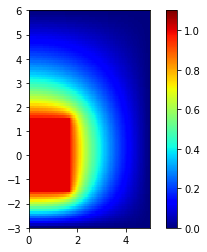

In [76]:
fig, ax = plt.subplots()
img = ax.imshow(sys.V.V.transpose(), origin='lower', extent=(rho_min,rho_max,z_min,z_max), cmap='jet', vmax=1.1)
cb = fig.colorbar(img, ax=ax)

# Construct a boundary condition array

## Define a conductor

In [32]:
cylin = ConductingCylinderOnGrid(sys.rho_arr, sys.z_arr, sys.rho_arr.size // 3, (sys.z_arr.size // 3) - (sys.z_arr.size // 6), (sys.z_arr.size // 3) + (sys.z_arr.size // 6), V0=1.0)

In [25]:
bd_cond = np.ma.array(np.full(grid_shape, -1e10, dtype=float), mask=True)

# Bounding box
V_box_boundary = 0.0
bd_cond.mask[:,[0,-1]] = False
bd_cond[:,[0,-1]] = V_box_boundary

bd_cond.mask[-1,:] = False
bd_cond[-1,:] = V_box_boundary

if rho_arr[0] > 0: 
    bd_cond.mask[0,:] = False
    bd_cond[0,:] = V_box_boundary
             
# A cylinder
bd_cond.mask[cylin.mask] = False
bd_cond[cylin.mask] = cylin.V0

In [41]:
V = Electric_Potential_At_Cylindrical_Coord(sys.rho_arr, sys.z_arr, sys.bd_cond)

In [27]:
V.go_to_solution()

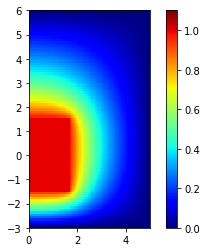

In [28]:
fig, ax = plt.subplots()
img = ax.imshow(V.V.transpose(), origin='lower', extent=(rho_min,rho_max,z_min,z_max), cmap='jet', vmax=1.1)
cb = fig.colorbar(img, ax=ax)

In [29]:
Q_total = cylin.get_total_charge(V.V)

Capci = Q_total / (cylin.V0 - V_box_boundary)

# Plot the capatitence as a function of offset of the cylinder from the outer boundary

In [23]:
s1_rho_arr = rho_arr[np.array(cylin.s1_ind)[:,0]]
s1_rho_grid = np.empty((len(cylin.s1_ind)+1,))
s1_rho_grid[0] = s1_rho_arr[0] - 0.5*delta_rho
s1_rho_grid[-1] = s1_rho_arr[-1] + 0.5*delta_rho
s1_rho_grid[1:-1] = 0.5 * (s1_rho_arr[:-1] + s1_rho_arr[1:])

s1_z_arr = z_arr[np.array(cylin.s1_ind)[0,0]].reshape(1,)
s1_z_grid = np.array((cylin.zu-0.5*delta_z,cylin.zu+0.5*delta_z))
# construct_catesian_mesh_for_pcolormesh(s1_rho_arr, s1_z_arr)

s1_Rho, s1_Z = np.meshgrid(s1_rho_grid, s1_z_grid, indexing='ij')

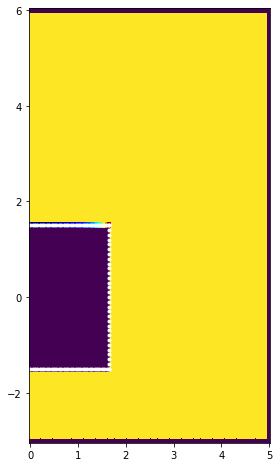

In [31]:
from vis.plot import construct_catesian_mesh_for_pcolormesh
Rho_mesh, Z_mesh = construct_catesian_mesh_for_pcolormesh(rho_arr, z_arr)

figg ,axx = plt.subplots(figsize=(6,8))
axx.pcolormesh(Rho_mesh, Z_mesh, bd_cond.mask)
axx.set_aspect(1.0)

for (rho_ind, z_ind) in surf_points_ind:
    rho, z = rho_arr[rho_ind], z_arr[z_ind]
    axx.plot(rho, z, '.', color='white')
# axx.plot(surf_points[:,0], surf_points[:,1],'.')
# axx.imshow(bd_cond.mask)

axx.pcolormesh(s1_Rho, s1_Z, s1_sigma.reshape((s1_sigma.size,1)), cmap='jet')

# figg.savefig("mask-with-surf-and-near-points-test-1.png")

In [19]:
phi_arr = np.linspace(0,2*pi,51)

In [20]:
sigma = np.array([*s1_sigma, *s2_sigma, *s3_sigma])
ch_max, ch_min = sigma.max(), sigma.min()

# vmax = max(abs(ch_max), abs(ch_min))
# vmin = -vmax

vmin, vmax = ch_min, ch_max

norm = Normalize(vmin, vmax, clip=True)

# ch_cm = cm.seismic
ch_cm = cm.jet

In [21]:
s1_3d_rho_grid = np.empty((s1_rho_arr.size+1,))
s1_3d_rho_grid[1:-1] = 0.5 * (s1_rho_arr[:-1] + s1_rho_arr[1:])
s1_3d_rho_grid[0] = 0.0
s1_3d_rho_grid[-1] = R

In [22]:
S1_3D_Rho_Grid, S1_3D_Phi_Grid = np.meshgrid(s1_3d_rho_grid, phi_arr)
S1_3D_X = S1_3D_Rho_Grid * cos(S1_3D_Phi_Grid)
S1_3D_Y = S1_3D_Rho_Grid * sin(S1_3D_Phi_Grid)
S1_3D_Z = np.full_like(S1_3D_X, z_cy_max)

# S1_3D_Rho, S1_3D_Phi = np.meshgrid(s1_rho_arr, phi_arr)
# S1_3D_X = S1_3D_Rho * cos(S1_3D_Phi)
# S1_3D_Y = S1_3D_Rho * sin(S1_3D_Phi)
# S1_3D_Z = np.full_like(S1_3D_X, z_cy_max)

S1_Colors = np.empty((phi_arr.size, s1_rho_arr.size))
S1_Colors[:] = s1_sigma

# s1_norm = Normalize(S1_Colors.min(), S1_Colors.max(), clip=True)
S1_C = ch_cm(norm(S1_Colors))

In [23]:
s3_rho_arr = s1_rho_arr
s3_3d_rho_grid = s1_3d_rho_grid
S3_3D_Rho_Grid, S3_3D_Phi_Grid = np.meshgrid(s3_3d_rho_grid, phi_arr)
S3_3D_X = S3_3D_Rho_Grid * cos(S3_3D_Phi_Grid)
S3_3D_Y = S3_3D_Rho_Grid * sin(S3_3D_Phi_Grid)
S3_3D_Z = np.full_like(S3_3D_X, z_cy_min)

S3_Colors = np.empty((phi_arr.size, s3_rho_arr.size))
S3_Colors[:] = s3_sigma

# s3_norm = Normalize(S3_Colors.min(), S3_Colors.max(), clip=True)
S3_C = ch_cm(norm(S3_Colors))

In [24]:
s2_z_arr = z_arr[np.array(s2_ind)[:,1]]

s2_3d_z_grid = np.empty(s2_z_arr.size + 1,)
s2_3d_z_grid[0] = s2_z_arr[0]
s2_3d_z_grid[1:-1] = 0.5 * (s2_z_arr[:-1] + s2_z_arr[1:])
s2_3d_z_grid[-1] = s2_z_arr[-1]

S2_3D_Z_Grid, S2_3D_Phi_Grid = np.meshgrid(s2_3d_z_grid, phi_arr)
S2_3D_X = R * cos(S2_3D_Phi_Grid)
S2_3D_Y = R * sin(S2_3D_Phi_Grid)
S2_3D_Z = S2_3D_Z_Grid

S2_Colors = np.empty((phi_arr.size, s2_z_arr.size))
S2_Colors[:] = s2_sigma

# s2_norm = Normalize(S2_Colors.min(), S2_Colors.max(), clip=True)
S2_C = ch_cm(norm(S2_Colors))

(-2, 2)

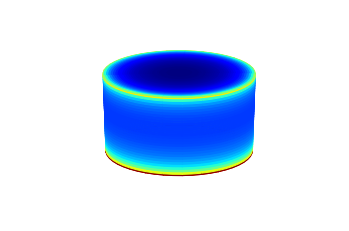

In [26]:
from mpl_toolkits.mplot3d import Axes3D

fig3, ax3 = plt.subplots(subplot_kw={'projection':'3d'})

s2_cc = ax3.plot_surface(S2_3D_X, S2_3D_Y, S2_3D_Z, facecolors=S2_C, cmap=ch_cm)
s1_cc = ax3.plot_surface(S1_3D_X, S1_3D_Y, S1_3D_Z, facecolors=S1_C, cmap=ch_cm)
s3_cc = ax3.plot_surface(S3_3D_X, S3_3D_Y, S3_3D_Z, facecolors=S3_C, cmap=ch_cm)

ax3.view_init(elev=30, azim=None)

ax3.set_axis_off()

ax3.set_xlim(-2,2)
ax3.set_ylim(-2,2)
ax3.set_zlim(-2,2)

# s1_cc.set_clim(S1_Colors.min(), S1_Colors.max())
# s1_cb = fig3.colorbar(s1_cc, ax=ax3)

In [27]:
# fig3.savefig("charge-density-test-5.png")

# Eval and Draw E field line

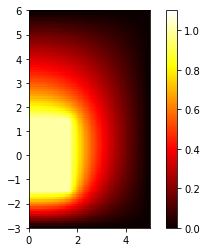

In [28]:
fig, ax = plt.subplots()
img = ax.imshow(V.V.transpose(), origin='lower', extent=(rho_min,rho_max,z_min,z_max), cmap='hot', vmax=1.1)
cb = fig.colorbar(img, ax=ax)

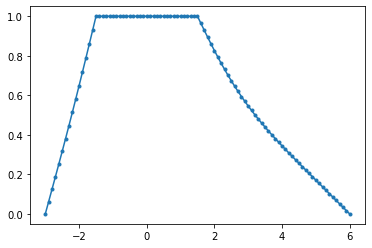

In [29]:
figs, axs = plt.subplots()
axs.plot(z_arr, V[4], '.-')

In [30]:
fig_filename = "single-cylinder-V0={:.3f}-test-0.png".format(V0)
print(fig_filename)
# fig.savefig(fig_filename)

single-cylinder-V0=1.000-test-0.png
